<a href="https://www.kaggle.com/code/pierremonroy/septembertabularplayground?scriptVersionId=104880680" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd
import seaborn as sns
from itertools import product

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-sep-2022/train.csv
/kaggle/input/tabular-playground-series-sep-2022/test.csv


In [2]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [3]:
train = pd.read_csv('../input/tabular-playground-series-sep-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-sep-2022/test.csv')

In [4]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

## EDA

We basically have 4 dimensions under which we need to explore the data:
* time
* country
* store
* product

Given the categorical nature of the data, the most obvious would be to have a time series plot of each product's sales for each location (country + store) so 12 plots in total with 4 lines on each.

In [5]:
train

row_id       date  country       store  \
0           0 2017-01-01  Belgium  KaggleMart   
1           1 2017-01-01  Belgium  KaggleMart   
2           2 2017-01-01  Belgium  KaggleMart   
3           3 2017-01-01  Belgium  KaggleMart   
4           4 2017-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
70123   70123 2020-12-31    Spain  KaggleMart   
70124   70124 2020-12-31    Spain  KaggleRama   
70125   70125 2020-12-31    Spain  KaggleRama   
70126   70126 2020-12-31    Spain  KaggleRama   
70127   70127 2020-12-31    Spain  KaggleRama   

                                product  num_sold  
0            Kaggle Advanced Techniques       663  
1                Kaggle Getting Started       615  
2                    Kaggle Recipe Book       480  
3      Kaggle for Kids: One Smart Goose       710  
4            Kaggle Advanced Techniques       240  
...                                 ...       ...  
70123  Kaggle for Kids: One Smart Goose       614  
70124        Kaggle Advanced Techniques       215  
70125            Kaggle Getting Started       158  
70126                Kaggle Recipe Book       135  
70127  Kaggle for Kids: One Smart Goose       202  

[70128 rows x 6 columns]

In [6]:
train.describe()

row_id      num_sold
count  70128.000000  70128.000000
mean   35063.500000    194.296986
std    20244.354176    126.893874
min        0.000000     19.000000
25%    17531.750000     95.000000
50%    35063.500000    148.000000
75%    52595.250000    283.000000
max    70127.000000    986.000000

In [7]:
test.describe()

row_id
count  17520.000000
mean   78887.500000
std     5057.732694
min    70128.000000
25%    74507.750000
50%    78887.500000
75%    83267.250000
max    87647.000000

In [8]:
test.head()

row_id       date  country       store                           product
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques

#### Checking if any NA

In [9]:
train.isna().sum()

row_id      0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [10]:
test.isna().sum()

row_id     0
date       0
country    0
store      0
product    0
dtype: int64

#### Checking categorical unique values

In [11]:
print(train['product'].unique())

['Kaggle Advanced Techniques' 'Kaggle Getting Started'
 'Kaggle Recipe Book' 'Kaggle for Kids: One Smart Goose']


In [12]:
print(test['product'].unique())

['Kaggle Advanced Techniques' 'Kaggle Getting Started'
 'Kaggle Recipe Book' 'Kaggle for Kids: One Smart Goose']


In [13]:
print(train['country'].unique())

['Belgium' 'France' 'Germany' 'Italy' 'Poland' 'Spain']


In [14]:
print(test['country'].unique())

['Belgium' 'France' 'Germany' 'Italy' 'Poland' 'Spain']


In [15]:
print(train['store'].unique())

['KaggleMart' 'KaggleRama']


In [16]:
print(test['store'].unique())

['KaggleMart' 'KaggleRama']


In [17]:
train['product'].unique()

array(['Kaggle Advanced Techniques', 'Kaggle Getting Started',
       'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'],
      dtype=object)

In [18]:
train.loc[train['product']=='Kaggle Advanced Techniques','product'] = 'A'
train.loc[train['product']=='Kaggle Getting Started','product'] = 'B'
train.loc[train['product']=='Kaggle Recipe Book','product'] = 'C'
train.loc[train['product']=='Kaggle for Kids: One Smart Goose','product'] = 'D'

In [19]:
test.loc[test['product']=='Kaggle Advanced Techniques','product'] = 'A'
test.loc[test['product']=='Kaggle Getting Started','product'] = 'B'
test.loc[test['product']=='Kaggle Recipe Book','product'] = 'C'
test.loc[test['product']=='Kaggle for Kids: One Smart Goose','product'] = 'D'

In [20]:
prods = train['product'].unique()
countries = train['country'].unique()
stores = train['store'].unique()

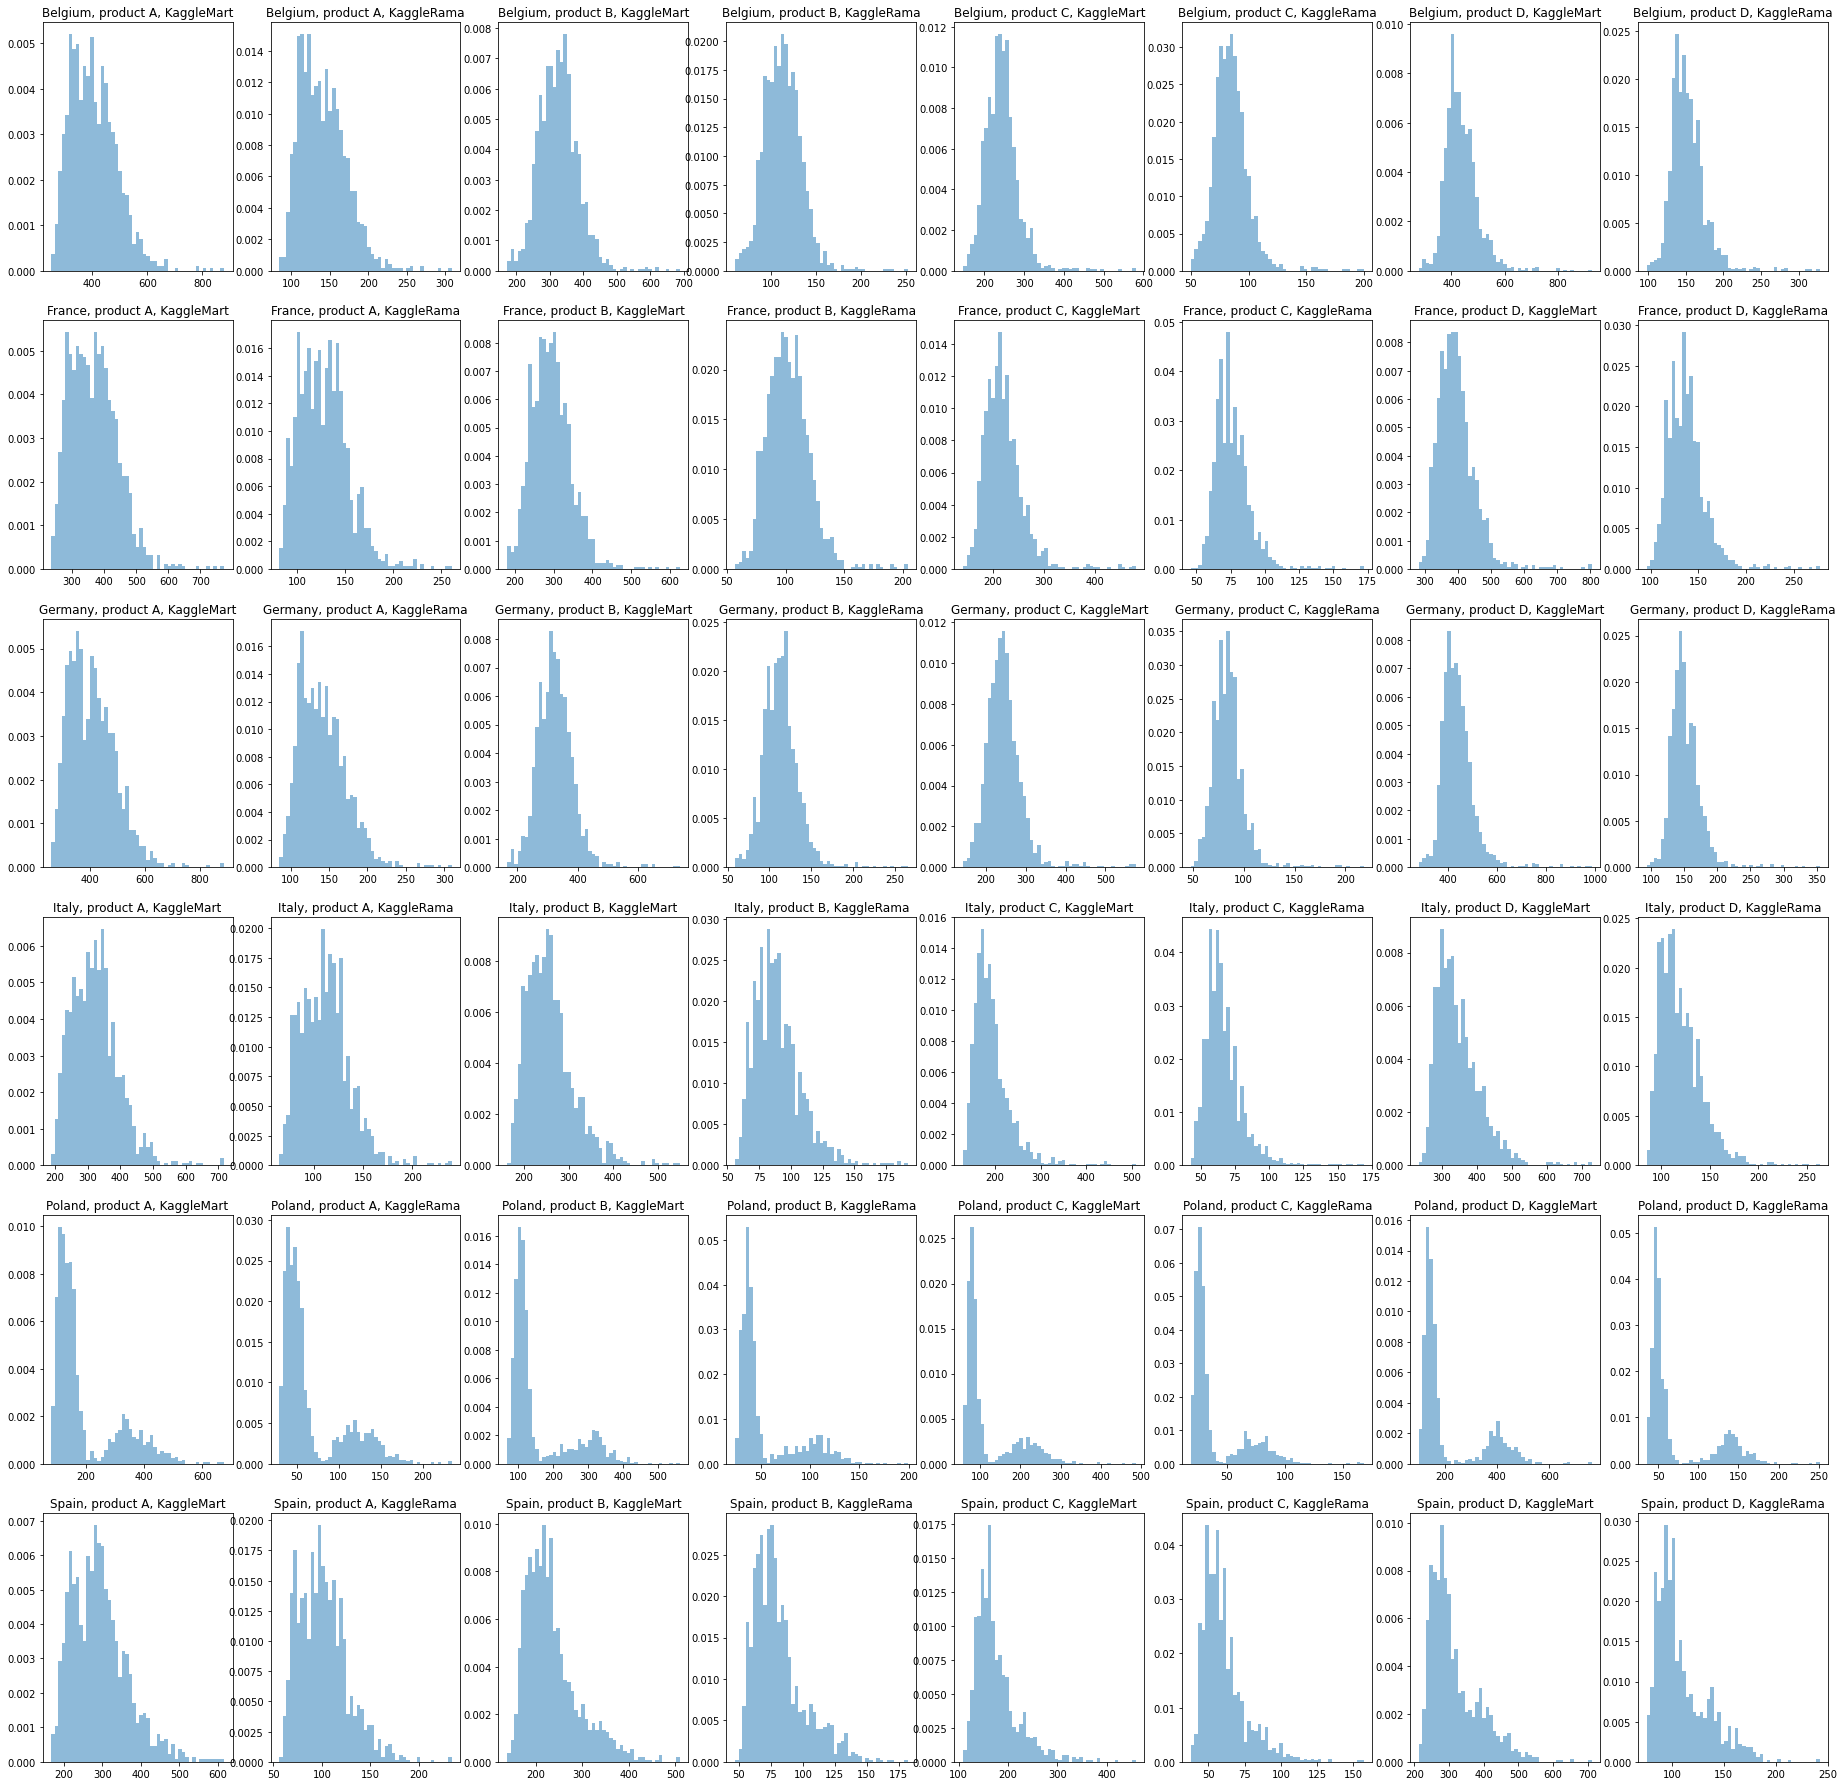

In [21]:
all_combinations = [x for x in product(countries, prods, stores)]

_, axs = plt.subplots(6,8, figsize=(32,32))

for x, ax in zip(all_combinations, axs.ravel()):
    tmp_train = train[(train['country'] == x[0]) & (train['product'] == x[1]) & (train['store'] == x[2])]

    mi = tmp_train['num_sold'].min()
    ma = tmp_train['num_sold'].max()
    bins = np.linspace(mi, ma, 50)
    ax.hist(tmp_train['num_sold'], bins=bins, alpha=0.5, density=True, label='train')
#     ax.set_ylabel(x[0])
    ax.set_title('{c}, product {p}, {s}'.format(c=x[0], p=x[1], s=x[2]))
    
plt.show()

In [22]:
train.dtypes

row_id               int64
date        datetime64[ns]
country             object
store               object
product             object
num_sold             int64
dtype: object

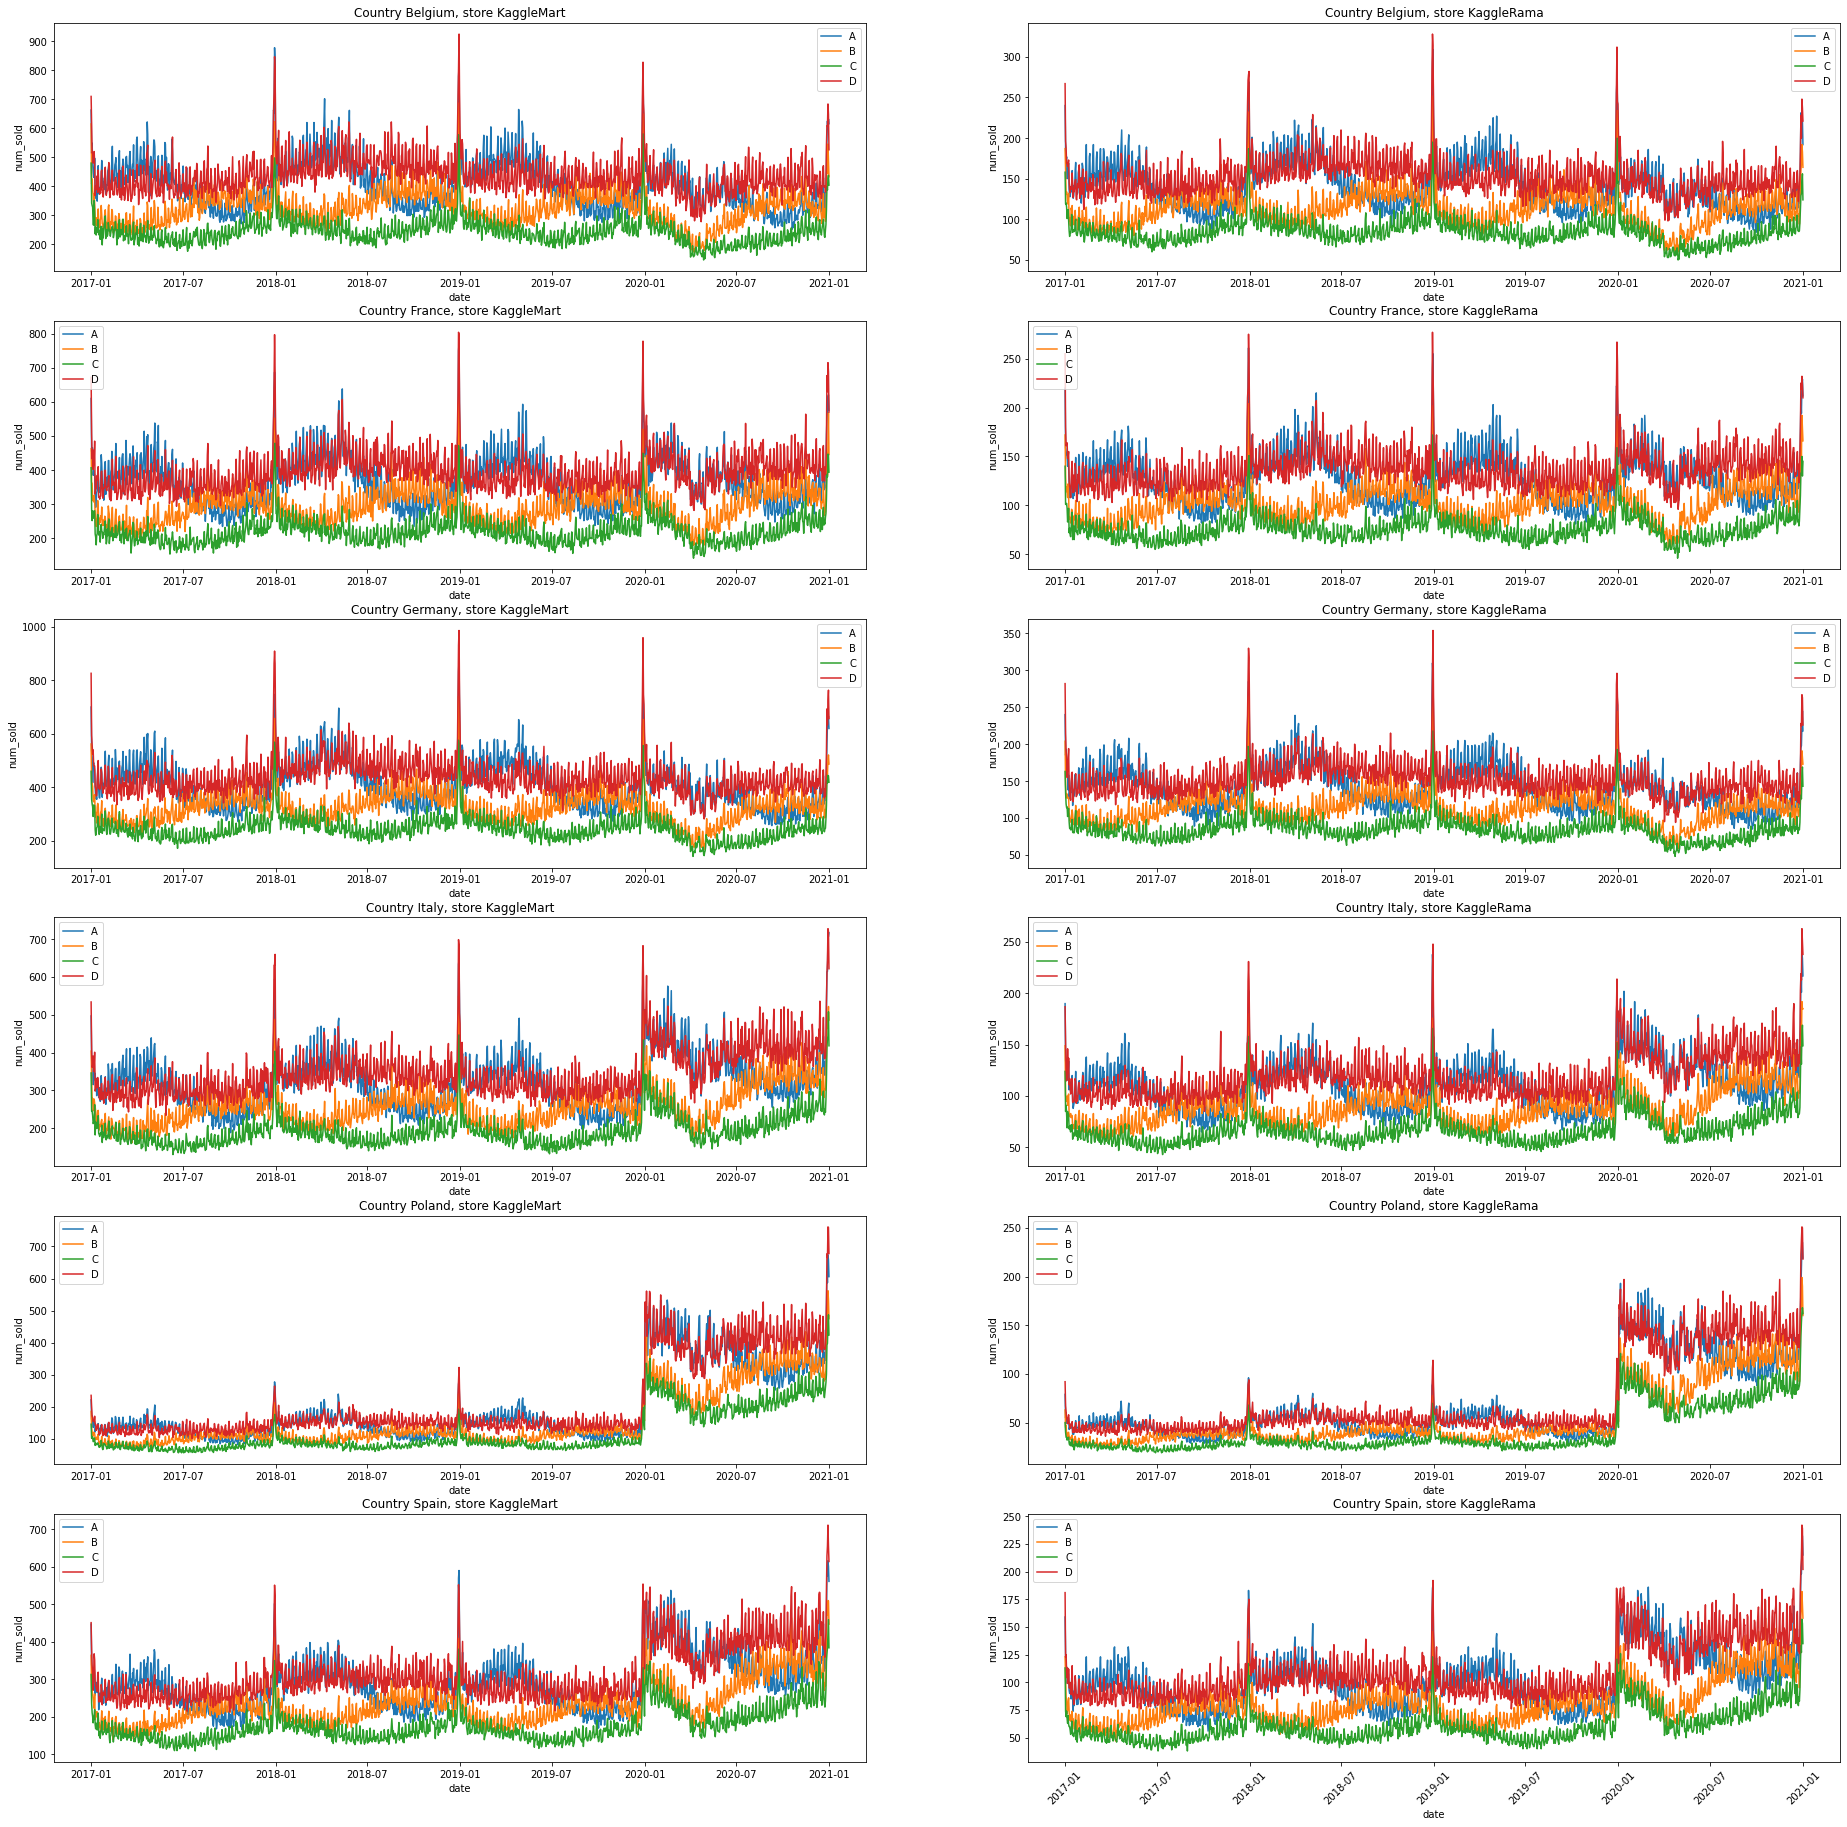

In [23]:
_, axs = plt.subplots(6,2, figsize=(32,32))

for x, ax in zip([x for x in product(countries, stores)], axs.ravel()):

    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'A') & (train['store'] == x[1]) & (train['country'] == x[0])], label="A",ax=ax)
    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'B') & (train['store'] == x[1]) & (train['country'] == x[0])], label="B",ax=ax)
    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'C') & (train['store'] == x[1]) & (train['country'] == x[0])], label="C",ax=ax)
    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'D') & (train['store'] == x[1]) & (train['country'] == x[0])], label="D",ax=ax)
    ax.set_title('Country {c}, store {s}'.format(c=x[0], s=x[1]))
    ax.legend()
    plt.xticks(rotation=45)
plt.show()

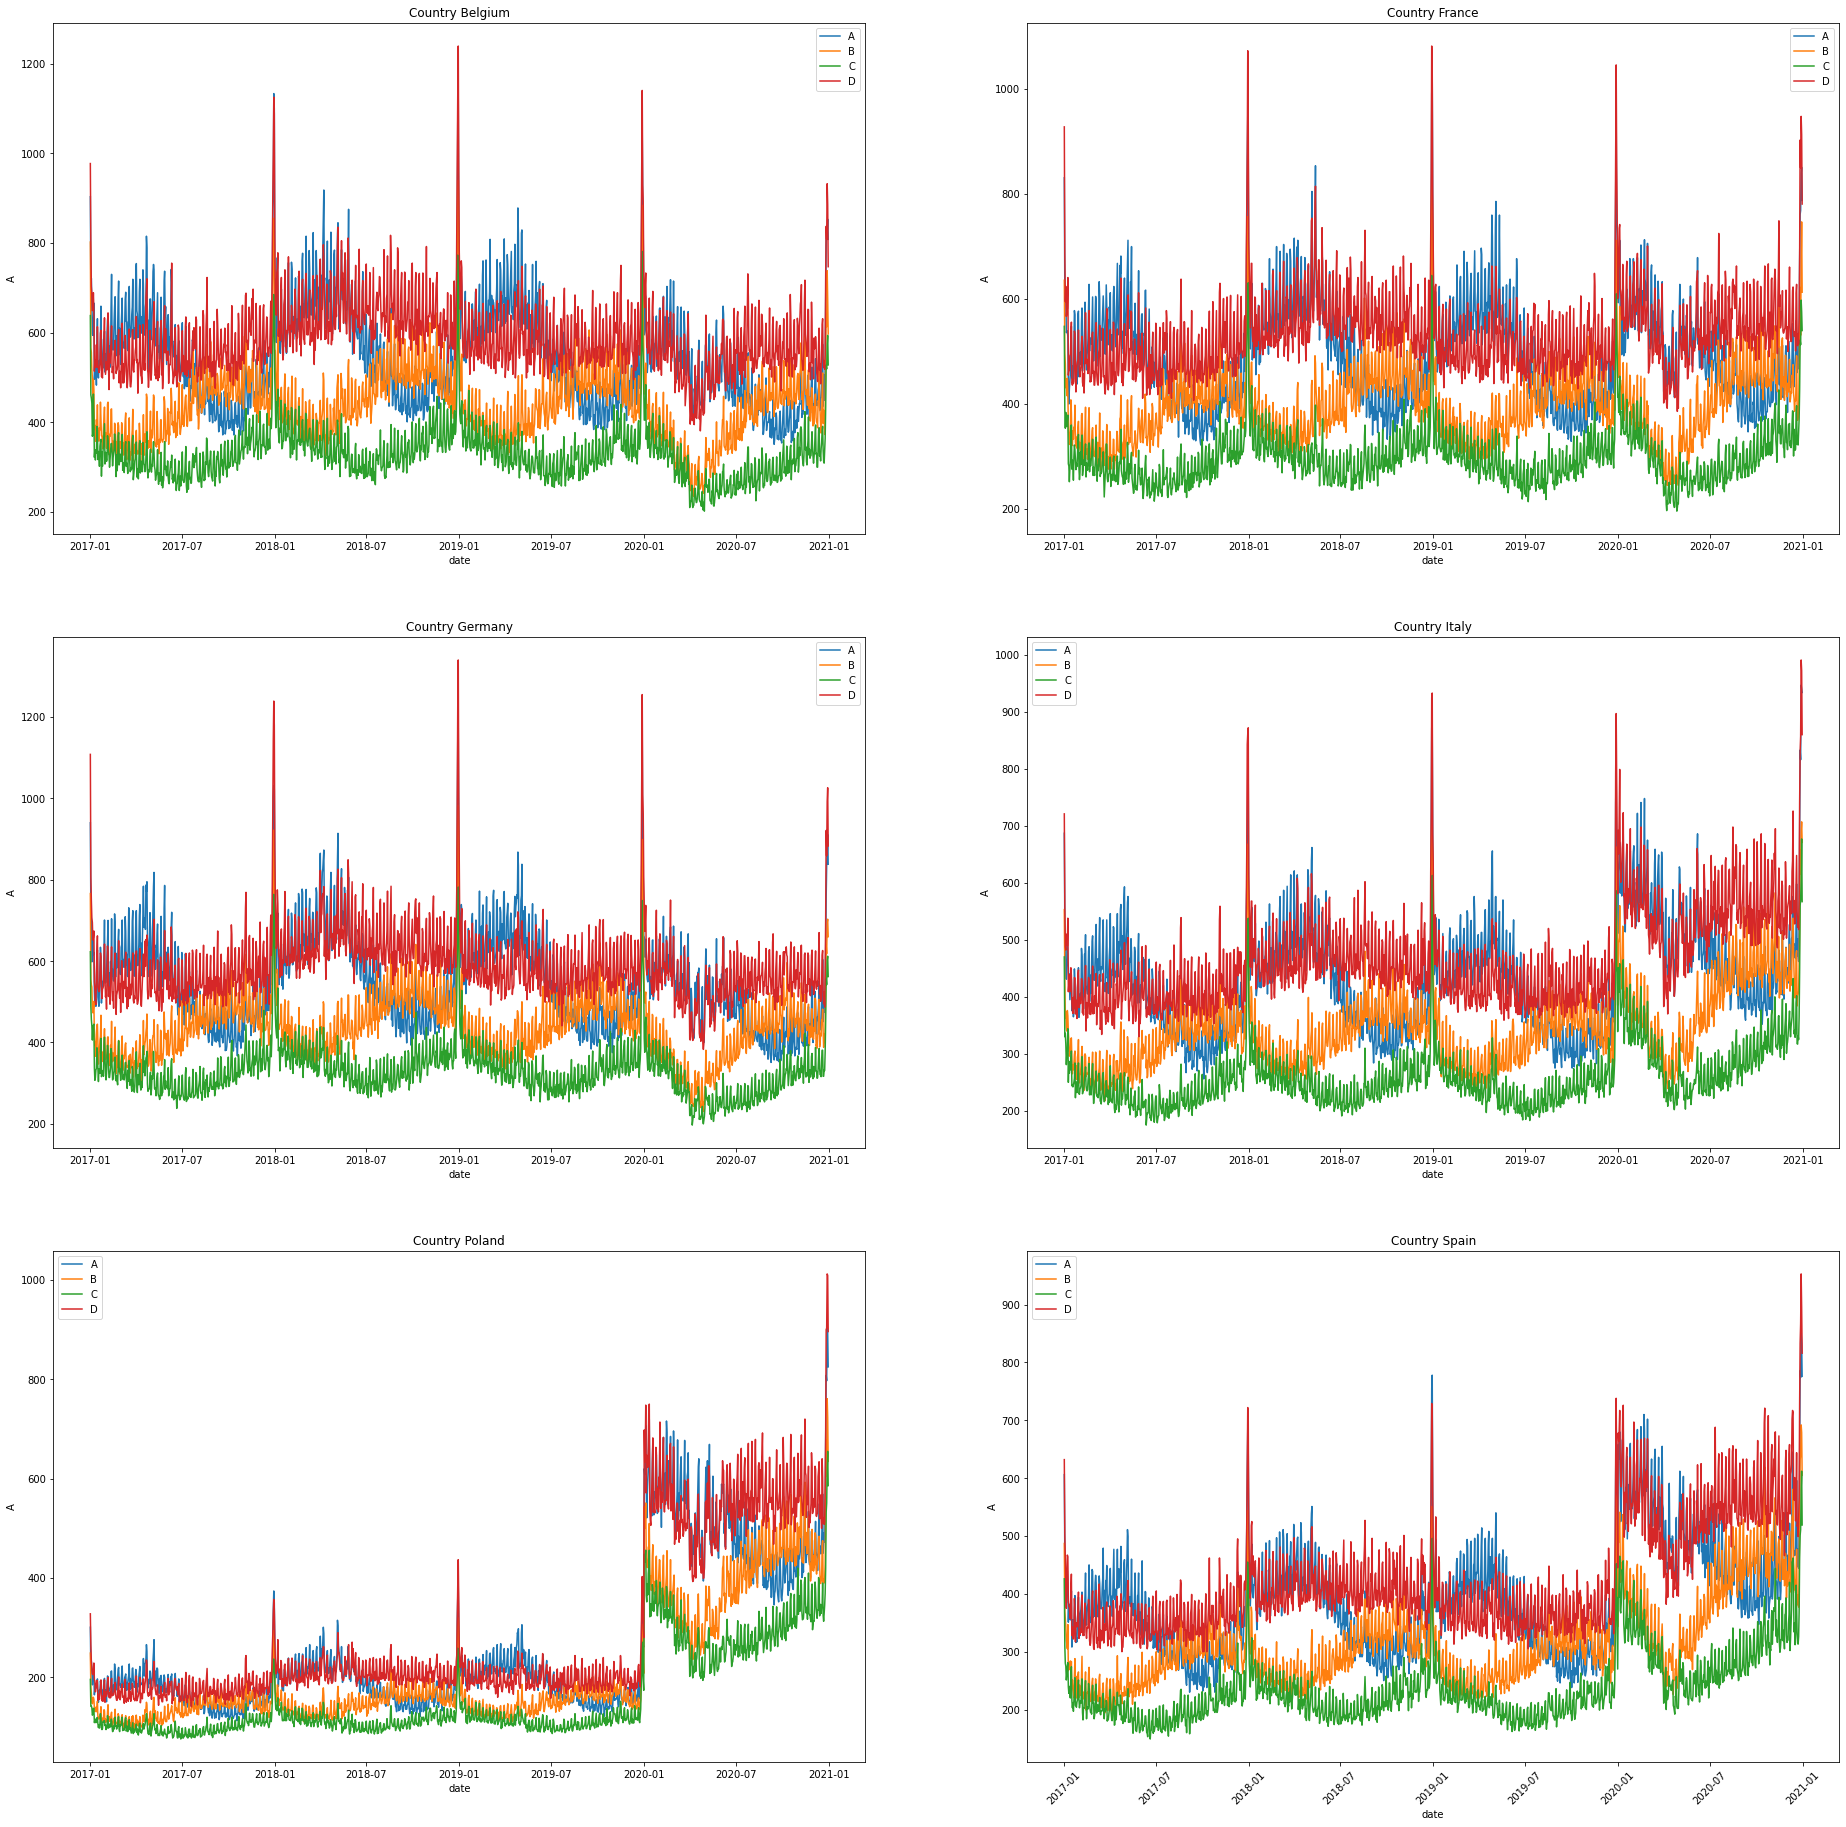

In [24]:
_, axs = plt.subplots(3,2, figsize=(32,32))

for x, ax in zip(countries, axs.ravel()):
    tmp_df = train[train['country'] == x].groupby(['date','product']).sum().unstack(1)
    sns.lineplot(x='date', y='A', data=tmp_df['num_sold'], label="A",ax=ax)
    sns.lineplot(x='date', y='B', data=tmp_df['num_sold'], label="B",ax=ax)
    sns.lineplot(x='date', y='C', data=tmp_df['num_sold'], label="C",ax=ax)
    sns.lineplot(x='date', y='D', data=tmp_df['num_sold'], label="D",ax=ax)
    ax.set_title('Country {c}'.format(c=x))
    ax.legend()
    plt.xticks(rotation=45)
plt.show()

In [25]:
train.groupby(['date','country']).sum()

row_id  num_sold
date       country                  
2017-01-01 Belgium      28      3320
           France       92      2939
           Germany     156      3437
           Italy       220      2431
           Poland      284      1074
...                    ...       ...
2020-12-31 France   560732      2718
           Germany  560796      2943
           Italy    560860      3032
           Poland   560924      2942
           Spain    560988      2716

[8766 rows x 2 columns]

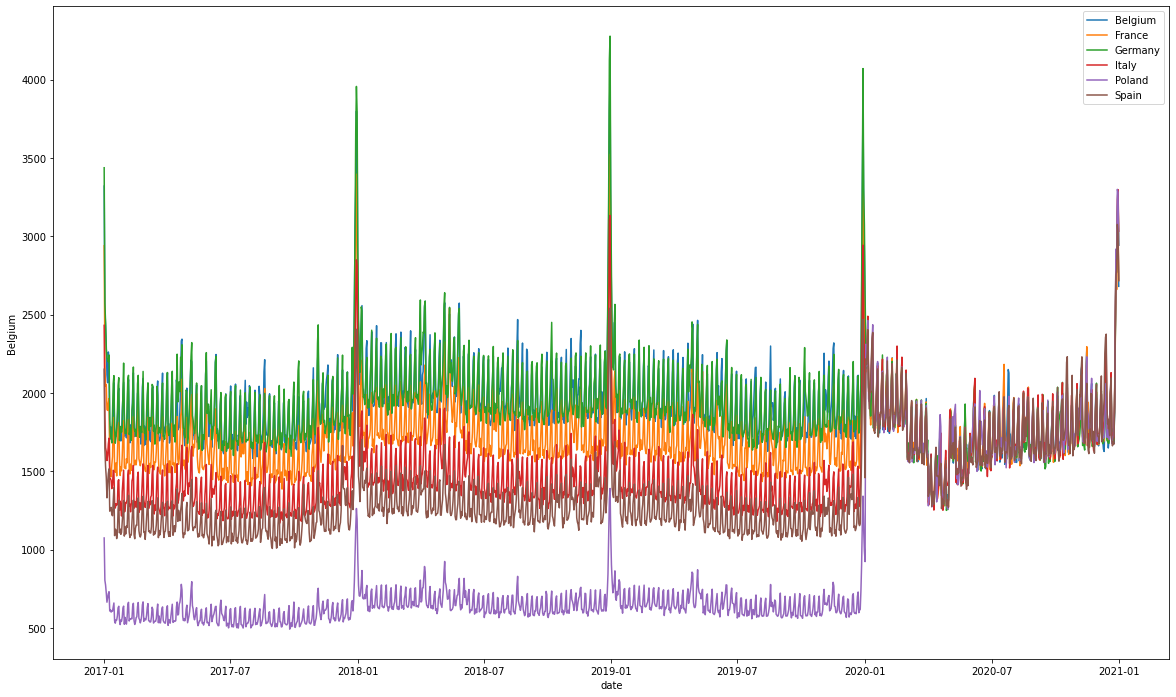

In [26]:
tmp_df = train.groupby(['date','country']).sum().unstack(1)['num_sold']

plt.figure(figsize=(20,12))

for country in countries:
    sns.lineplot(x='date', y=country, data=tmp_df, label=country)
    
plt.show()

### Stores Sales Ratio

Reproducing here the store ratio approach by https://www.kaggle.com/code/ehekatlact/tps2209-ridge-lgbm-eda-topdownapproach#EDA


<AxesSubplot:xlabel='date'>

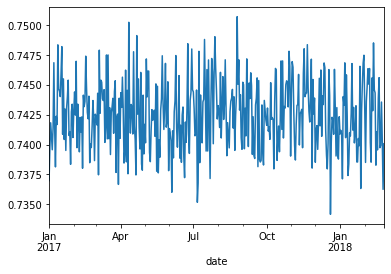

In [27]:
train_gp = train.loc[:'2020-01-01',:].groupby(['date','store']).sum().unstack(1)['num_sold']
train_gp['ratio'] = train_gp['KaggleMart'] / (train_gp['KaggleMart'] + train_gp['KaggleRama'])
train_gp['ratio'].plot()

In [28]:
train_gp['ratio']

date
2017-01-01    0.736972
2017-01-02    0.739679
2017-01-03    0.741823
2017-01-04    0.740641
2017-01-05    0.739561
                ...   
2018-02-21    0.739917
2018-02-22    0.743561
2018-02-23    0.740327
2018-02-24    0.736238
2018-02-25    0.740068
Name: ratio, Length: 421, dtype: float64

### Fourier Transform

Apart from a clear weekly seasonality, which we can model by adding day of the week indicator variables, it's hard to generalize seasonal observation from the periodograms but we could experiment with adding Fourier pairs to model seasonality in a regression.

In [29]:
### Reusing code from Kaggle Course: https://www.kaggle.com/code/ryanholbrook/seasonality

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """


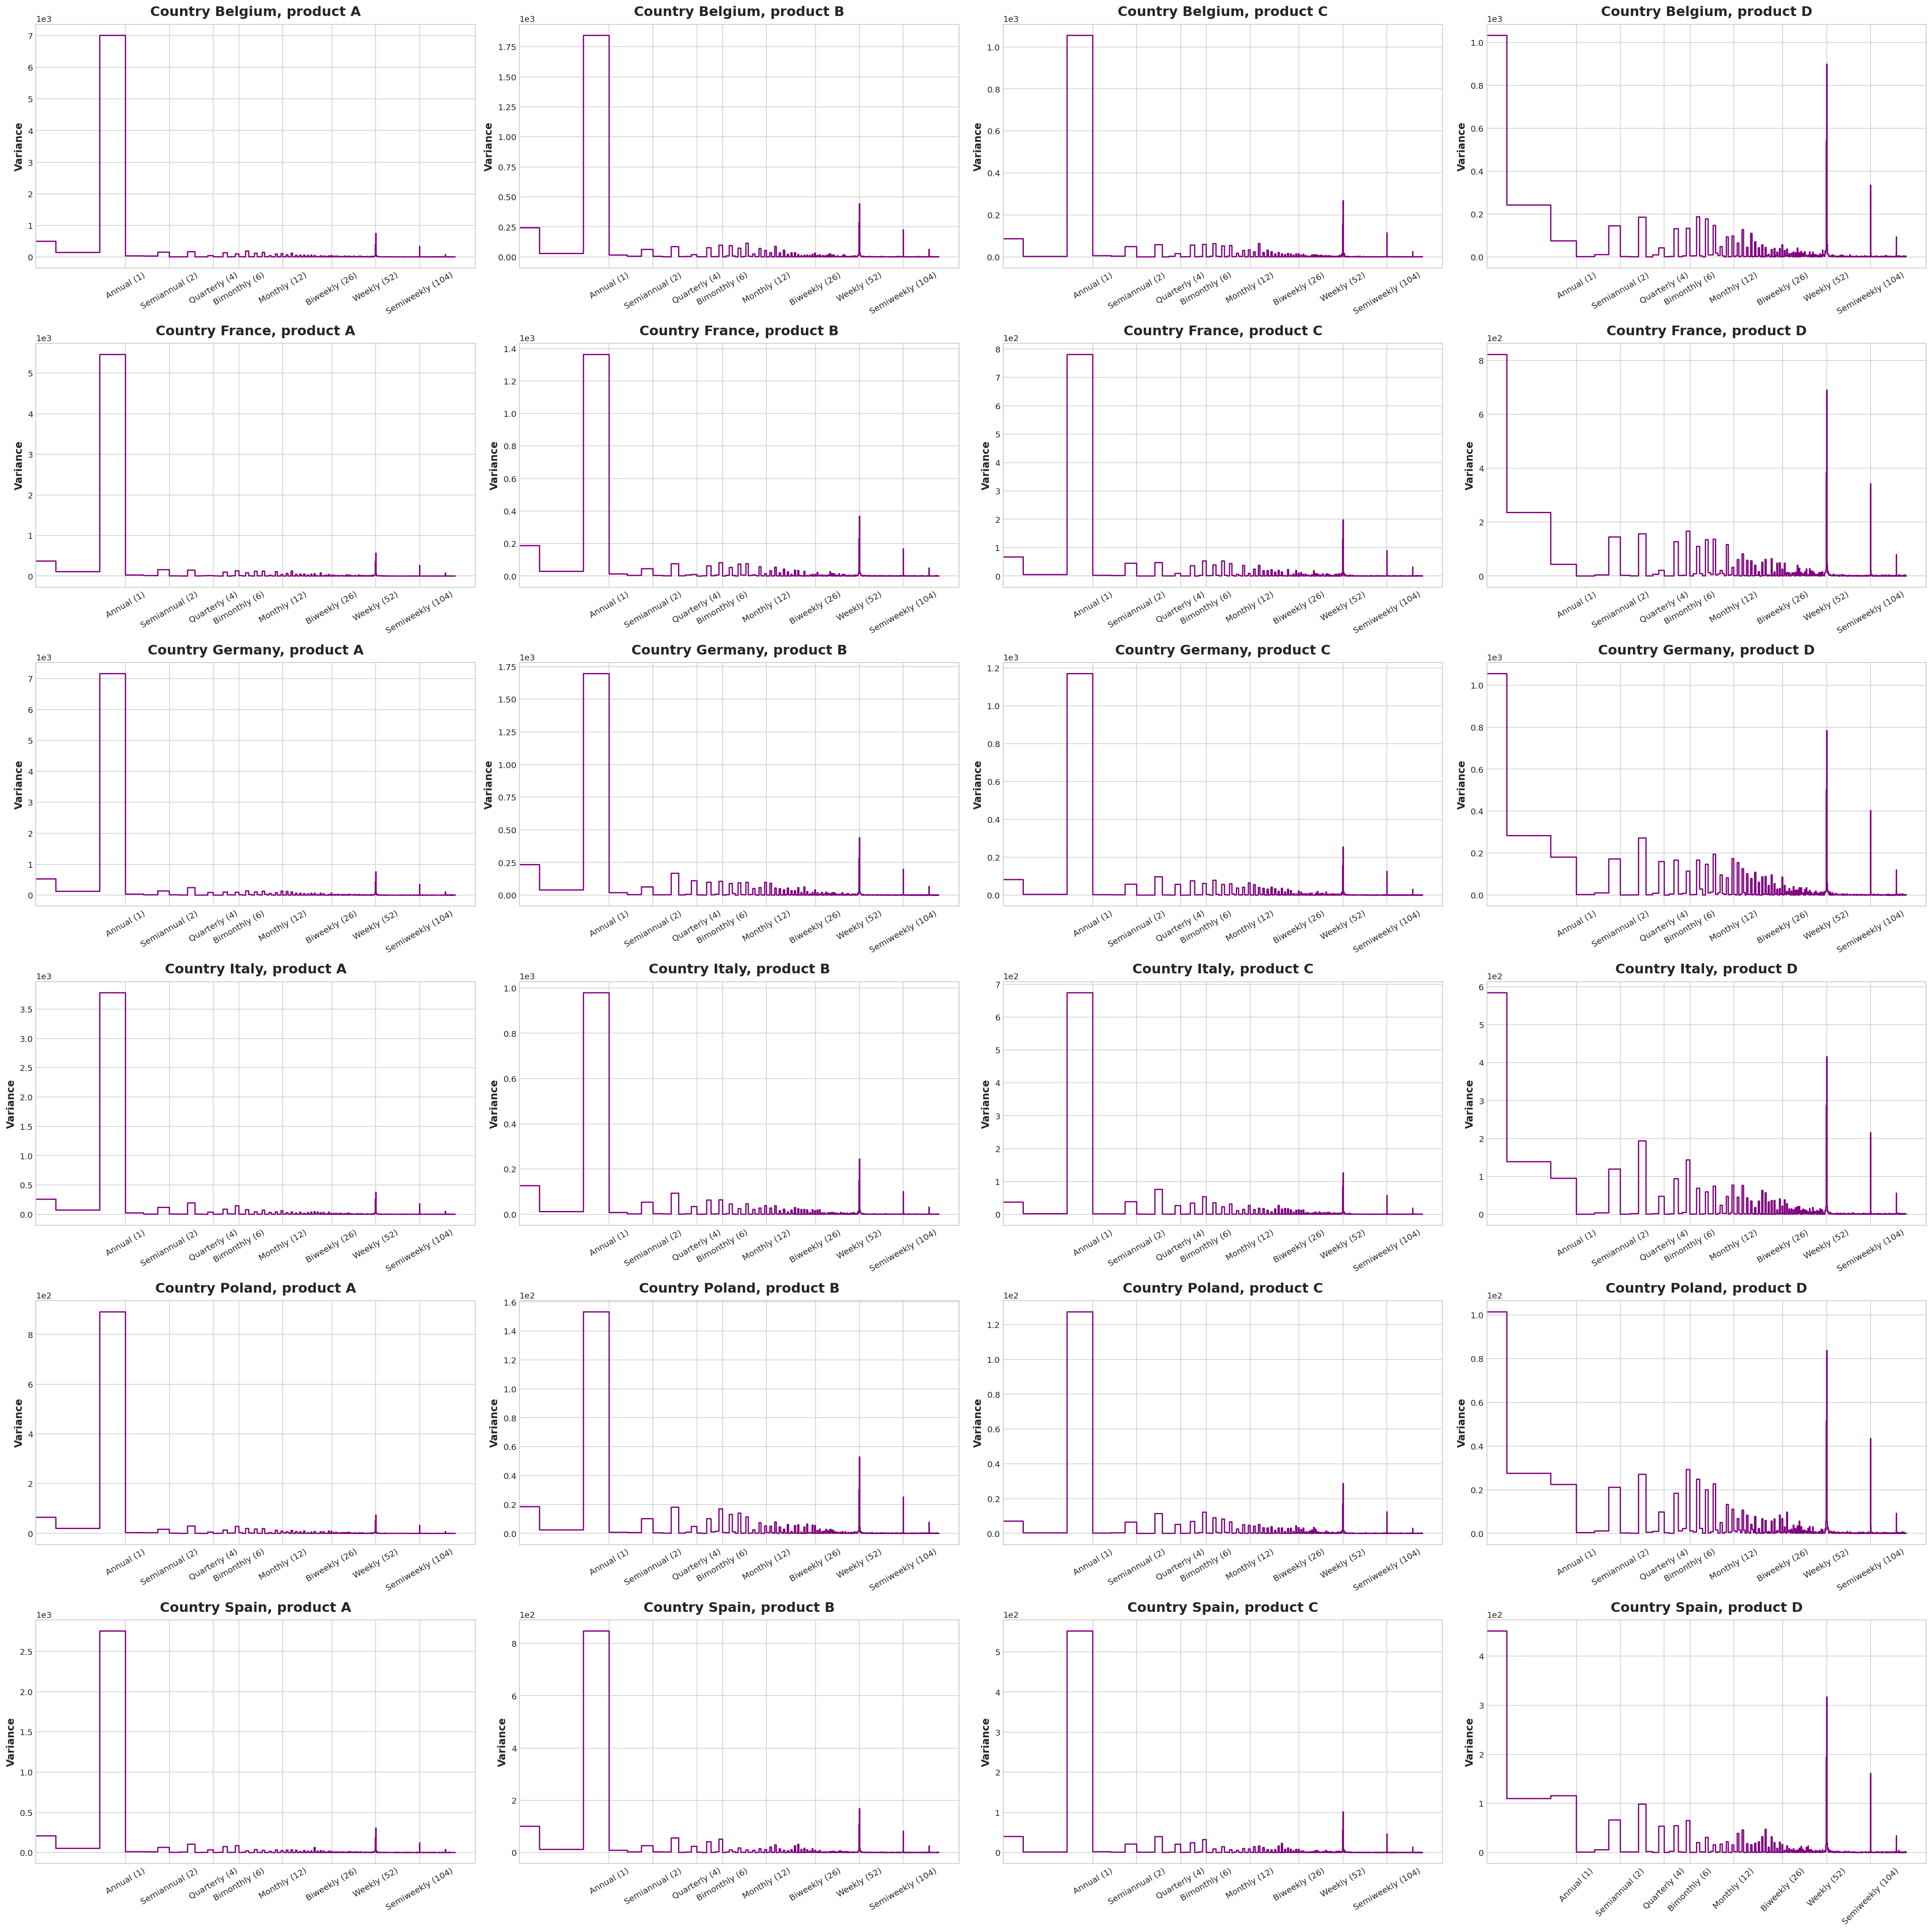

In [30]:
_, axs = plt.subplots(6,4, figsize=(32,32))

for x, ax in zip(product(countries, prods), axs.ravel()):
    tmp_df = train[(train['country'] == x[0])].groupby(['date','product']).sum().unstack(1).loc[:'2020-01-01','num_sold']
    plot_periodogram(tmp_df[x[1]], ax=ax)
    ax.set_title('Country {c}, product {p}'.format(c=x[0], p=x[1]))
    ax.legend()
    plt.xticks(rotation=45)
plt.show()

In [31]:
train.groupby(['date','product']).sum()

row_id  num_sold
date       product                  
2017-01-01 A           264      4267
           B           276      3492
           C           288      2900
           D           300      4693
2017-01-02 A           840      3242
...                    ...       ...
2020-12-30 D        840684      5699
2020-12-31 A        841224      4968
           B        841236      3780
           C        841248      3301
           D        841260      4982

[5844 rows x 2 columns]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """


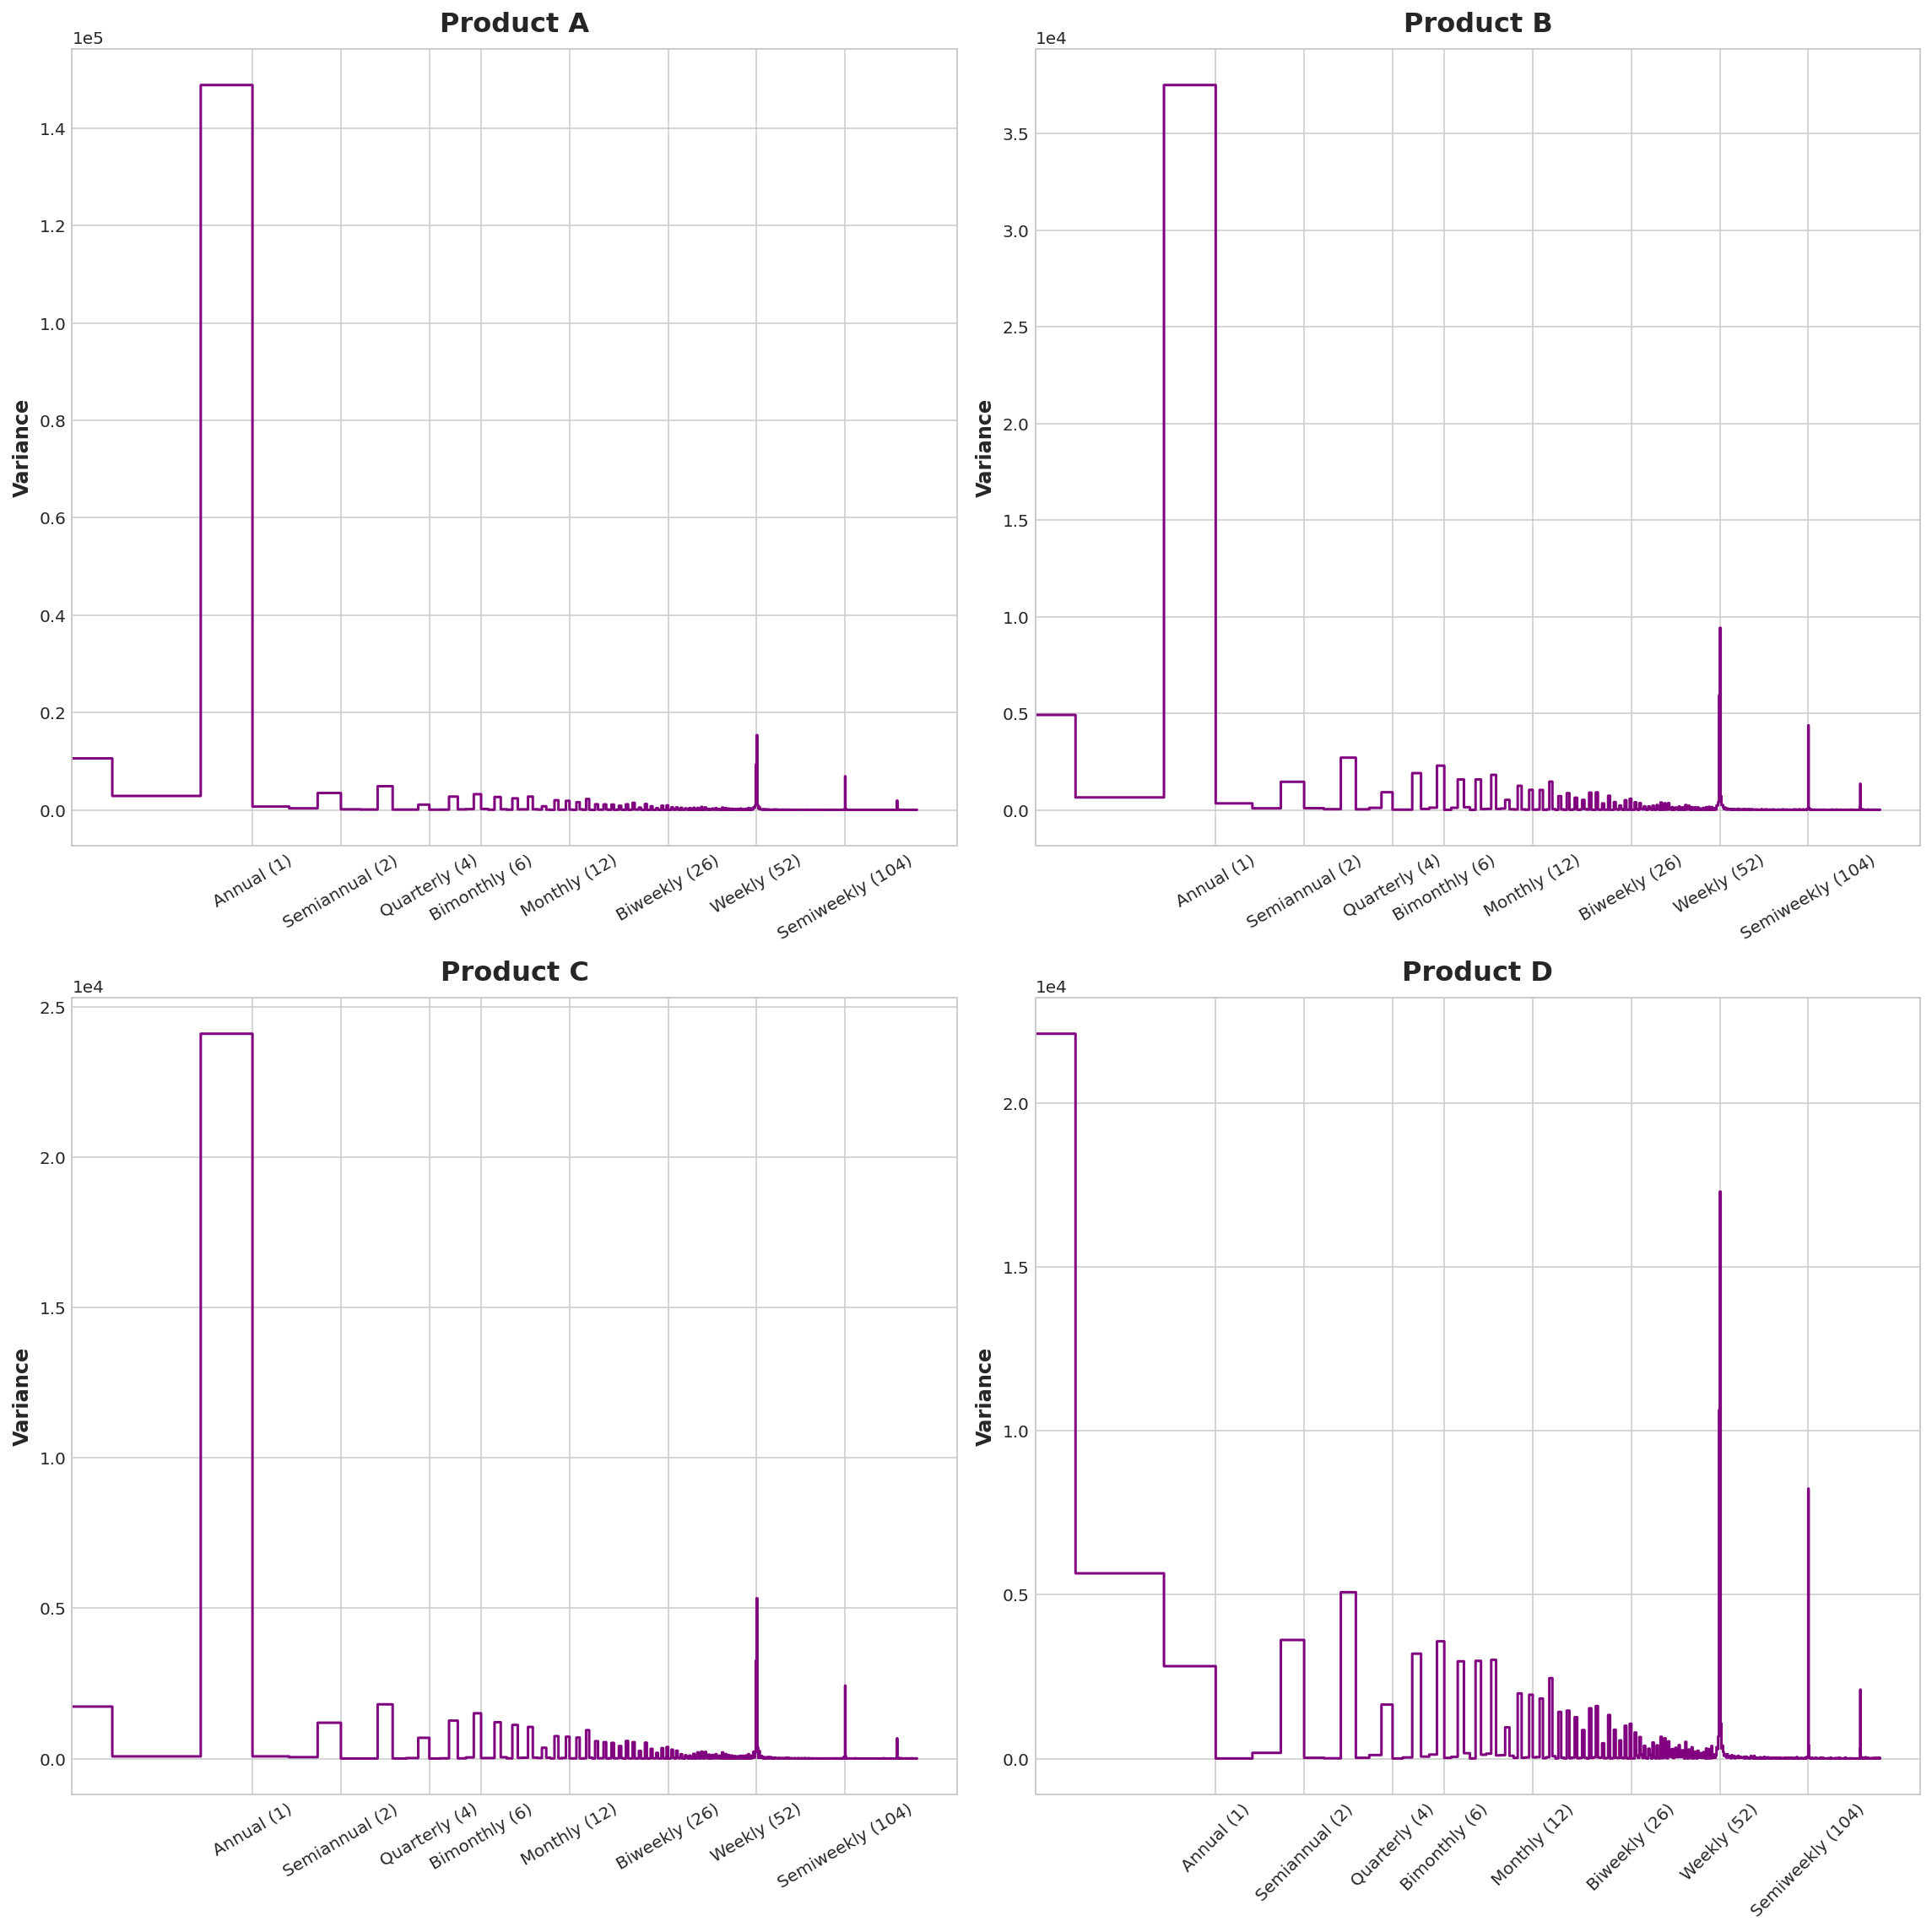

In [32]:
_, axs = plt.subplots(2,2, figsize=(16,16))

for x, ax in zip(prods, axs.ravel()):
    tmp_df = train.groupby(['date','product']).sum().unstack(1).loc[:'2020-01-01','num_sold']
    plot_periodogram(tmp_df[x], ax=ax)
    ax.set_title('Product {p}'.format(p=x))
    ax.legend()
    plt.xticks(rotation=45)
plt.show()

## Modelling 

* SARIMA
* Regression
 * Create day of the week and months features to capture seasonality
 * Add Fourier pairs

### Feature engineering

In [33]:
train['weekday'] = train['date'].apply(lambda x: x.weekday())
train['month'] = train['date'].apply(lambda x: x.month)

test['weekday'] = test['date'].apply(lambda x: x.weekday())
test['month'] = test['date'].apply(lambda x: x.month)

### SARIMA approach

In [34]:
# import statsmodels.api as sm
# from pylab import rcParams
# rcParams['figure.figsize'] = 18, 8
# decomposition = sm.tsa.seasonal_decompose(y, model='additive', period = 30)
# fig = decomposition.plot()
# plt.show()

In [35]:
p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 30
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

16


In [36]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in parameters_list:
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['params', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [37]:
def SARIMA_forecast(df):
    result_df = optimize_SARIMA(parameters_list, 1, 0, 30,df['num_sold'])
    p = result_df['params'].iloc[0]
    mod = SARIMAX(df['num_sold'],order=(p[0], 1, p[1]),
                seasonal_order=(p[2], 1, p[3], 30),
                enforce_stationarity=False,
                enforce_invertibility=False)
    res = mod.fit(disp=False)
    pred = res.get_forecast(steps = 365)
    
    return pred.predicted_mean, p

for x in product(countries, stores, prods):
    df = train[(train['country'] == x[0]) & (train['store'] == x[1]) & (train['product'] == x[2])]
    df = df.set_index('date').asfreq('D')
    
    pred, p = SARIMA_forecast(df)
    print('Combinations ({c}, {s}, {p}), optimal SARIMA params {params}'.format(c=x[0], s=x[1], p=x[2], params=p))
    
    new_index = test[(test['country'] == x[0]) & (test['store'] == x[1]) & (test['product'] == x[2])].index
    pred = pd.DataFrame(pred).set_index(new_index)
    
    if 'predicted_mean' in test.columns:
        test.loc[new_index,'predicted_mean'] = pred.loc[new_index,'predicted_mean']
    else:
        test = test.join(pred, how='left')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Combinations (Belgium, KaggleMart, A), optimal SARIMA params (1, 1, 1, 1)
Combinations (Belgium, KaggleMart, B), optimal SARIMA params (1, 1, 1, 1)
Combinations (Belgium, KaggleMart, C), optimal SARIMA params (1, 1, 1, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Combinations (Belgium, KaggleMart, D), optimal SARIMA params (1, 1, 1, 1)
Combinations (Belgium, KaggleRama, A), optimal SARIMA params (1, 1, 1, 1)
Combinations (Belgium, KaggleRama, B), optimal SARIMA params (1, 1, 1, 1)
Combinations (Belgium, KaggleRama, C), optimal SARIMA params (1, 1, 1, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Combinations (Belgium, KaggleRama, D), optimal SARIMA params (1, 1, 1, 1)
Combinations (France, KaggleMart, A), optimal SARIMA params (1, 1, 1, 1)
Combinations (France, KaggleMart, B), optimal SARIMA params (1, 1, 1, 1)
Combinations (France, KaggleMart, C), optimal SARIMA params (1, 1, 1, 1)
Combinations (France, KaggleMart, D), optimal SARIMA params (1, 1, 1, 1)
Combinations (France, KaggleRama, A), optimal SARIMA params (1, 1, 1, 1)
Combinations (France, KaggleRama, B), optimal SARIMA params (1, 1, 1, 1)
Combinations (France, KaggleRama, C), optimal SARIMA params (1, 1, 0, 1)
Combinations (France, KaggleRama, D), optimal SARIMA params (1, 1, 1, 1)
Combinations (Germany, KaggleMart, A), optimal SARIMA params (1, 1, 1, 1)
Combinations (Germany, KaggleMart, B), optimal SARIMA params (1, 1, 1, 1)
Combinations (Germany, KaggleMart, C), optimal SARIMA params (1, 1, 1, 1)
Combinations (Germany, KaggleMart, D), optimal SARIMA params (1, 1, 1, 1)
Combinations (Germany, KaggleRama, A), optimal

In [38]:
test[['row_id','predicted_mean']].rename(columns={'predicted_mean':'num_sold'}).set_index('row_id').to_csv('submission.csv')

In [39]:
# X = df[["country","product","weekday","month", "rolling_ave"]]
# y = df["num_sold"]

# categorical_features = ["country","product","weekday","month"]
# categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("cat", categorical_transformer, categorical_features),
#     ]
# )

# clf = Pipeline(
#     steps=[("preprocessor", preprocessor), ("classifier", GradientBoostingRegressor())]
# )

# tscv = TimeSeriesSplit()

# for train_idx, test_idx in tscv.split(X):
#     clf.fit(X.iloc[train_idx], y.iloc[train_idx])
#     print("model score: %.3f" % clf.score(X.iloc[test_idx], y.iloc[test_idx]))

In [40]:
### Reusing code from Kaggle Course: https://www.kaggle.com/code/ryanholbrook/seasonality

fourier = CalendarFourier(freq="A", order=2)  # 2 sin/cos pairs

dp = DeterministicProcess(
    index=tmp_df.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index



In [41]:
X

const   trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                        
2017-01-01    1.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-02    1.0     2.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-01-03    1.0     3.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-01-04    1.0     4.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-01-05    1.0     5.0     0.0     0.0     0.0     1.0     0.0     0.0   
...           ...     ...     ...     ...     ...     ...     ...     ...   
2019-12-28    1.0  1092.0     0.0     0.0     0.0     0.0     0.0     1.0   
2019-12-29    1.0  1093.0     0.0     0.0     0.0     0.0     0.0     0.0   
2019-12-30    1.0  1094.0     1.0     0.0     0.0     0.0     0.0     0.0   
2019-12-31    1.0  1095.0     0.0     1.0     0.0     0.0     0.0     0.0   
2020-01-01    1.0  1096.0     0.0     0.0     1.0     0.0     0.0     0.0   

            sin(1,freq=A-DEC)  cos(1,freq=A-DEC)  sin(2,freq=A-DEC)  \
date                                                                  
2017-01-01           0.000000           1.000000           0.000000   
2017-01-02           0.017213           0.999852           0.034422   
2017-01-03           0.034422           0.999407           0.068802   
2017-01-04           0.051620           0.998667           0.103102   
2017-01-05           0.068802           0.997630           0.137279   
...                       ...                ...                ...   
2019-12-28          -0.068802           0.997630          -0.137279   
2019-12-29          -0.051620           0.998667          -0.103102   
2019-12-30          -0.034422           0.999407          -0.068802   
2019-12-31          -0.017213           0.999852          -0.034422   
2020-01-01           0.000000           1.000000           0.000000   

            cos(2,freq=A-DEC)  
date                           
2017-01-01           1.000000  
2017-01-02           0.999407  
2017-01-03           0.997630  
2017-01-04           0.994671  
2017-01-05           0.990532  
...                       ...  
2019-12-28           0.990532  
2019-12-29           0.994671  
2019-12-30           0.997630  
2019-12-31           0.999407  
2020-01-01           1.000000  

[1096 rows x 12 columns]